<a href="https://colab.research.google.com/github/KoreTane/An-lise-GLP/blob/main/An%C3%A1lisePre%C3%A7oGLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark
#!pip install folium geopandas
#!pip install requests

In [2]:
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql import functions as F
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from pyspark.sql.functions import year, month, count, avg, sum, to_date, col
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

drive.mount('/content/drive')

spark = SparkSession.builder \
    .appName("Análise de Preços do GLP") \
    .getOrCreate()

# Caminho para a pasta no Google Drive onde os arquivos Parquet estão armazenados
#(convertemos anteriormente do formato CVS => parquet para melhoramos a eficiência de armazenamento e a velocidade de leitura
# permitindo análises mais rápidas e economizando espaço em disco)

parquet_folder_path = '/content/drive/My Drive/1dhA5CNHrywBWHxOgPRyLalCBmNVbCLof/'

# Carregando o arquivo Excel
localizacao_df = pd.read_excel('/content/drive/My Drive/1dhA5CNHrywBWHxOgPRyLalCBmNVbCLof/BR_Localidades.xlsx')
localizacao_df = spark.createDataFrame(localizacao_df)

# Lista de arquivos Parquet
parquet_files = [
    'glp2023-01.parquet',
    'glp2023-02.parquet',
    'glp2024-01.parquet',
    'precosglp2024-07.parquet',
    'precosglp2024-08.parquet'
]

parquet_dataframes = {
    file: spark.read.parquet(f'{parquet_folder_path}{file}')
    for file in parquet_files
}

union_df = (
    parquet_dataframes['glp2023-01.parquet']
    .union(parquet_dataframes['glp2023-02.parquet'])
    .union(parquet_dataframes['glp2024-01.parquet'])
    .union(parquet_dataframes['precosglp2024-07.parquet'])
    .union(parquet_dataframes['precosglp2024-08.parquet'])
)
union_df = union_df.withColumn("id_venda", F.monotonically_increasing_id())


colunas = ['id_venda'] + [col for col in union_df.columns if col != 'id_venda']
union_df = union_df.select(colunas)

print("Dados do DataFrame unido:")
union_df.printSchema()

union_df.describe().show()

union_df.show(10, truncate=False)

localizacao_df.printSchema()

localizacao_df.describe().show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dados do DataFrame unido:
root
 |-- id_venda: long (nullable = false)
 |-- Regiao - Sigla: string (nullable = true)
 |-- Estado - Sigla: string (nullable = true)
 |-- Municipio: string (nullable = true)
 |-- Revenda: string (nullable = true)
 |-- CNPJ da Revenda: string (nullable = true)
 |-- Nome da Rua: string (nullable = true)
 |-- Numero Rua: string (nullable = true)
 |-- Complemento: string (nullable = true)
 |-- Bairro: string (nullable = true)
 |-- Cep: string (nullable = true)
 |-- Produto: string (nullable = true)
 |-- Data da Coleta: string (nullable = true)
 |-- Valor de Venda: string (nullable = true)
 |-- Valor de Compra: string (nullable = true)
 |-- Unidade de Medida: string (nullable = true)
 |-- Bandeira: string (nullable = true)

+-------+--------------------+--------------+--------------+----------+--------------------+-------------------+-

In [3]:
# TRATAMENTO DOS DADOS
# Completar valores nulos na coluna 'Complemento'
union_df = union_df.fillna('Não Informado', subset=['Complemento'])

# Remover as colunas especificadas que não fazem sentido para o modelo
colunas_a_remover = ['Valor de Compra', 'Produto', 'Unidade de Medida', 'CNPJ da Revenda']
union_df = union_df.drop(*colunas_a_remover)

# Remover linhas onde "Valor de Venda" está em branco ou nulo
union_df = union_df.filter(col("Valor de Venda").isNotNull() & (col("Valor de Venda") != ""))
# Convertendo a coluna 'Data da Coleta' para o tipo de data
union_df = union_df.withColumn("Data da Coleta", to_date(union_df["Data da Coleta"], "dd/MM/yyyy"))
union_df = union_df.withColumn("Ano", year(union_df["Data da Coleta"]))

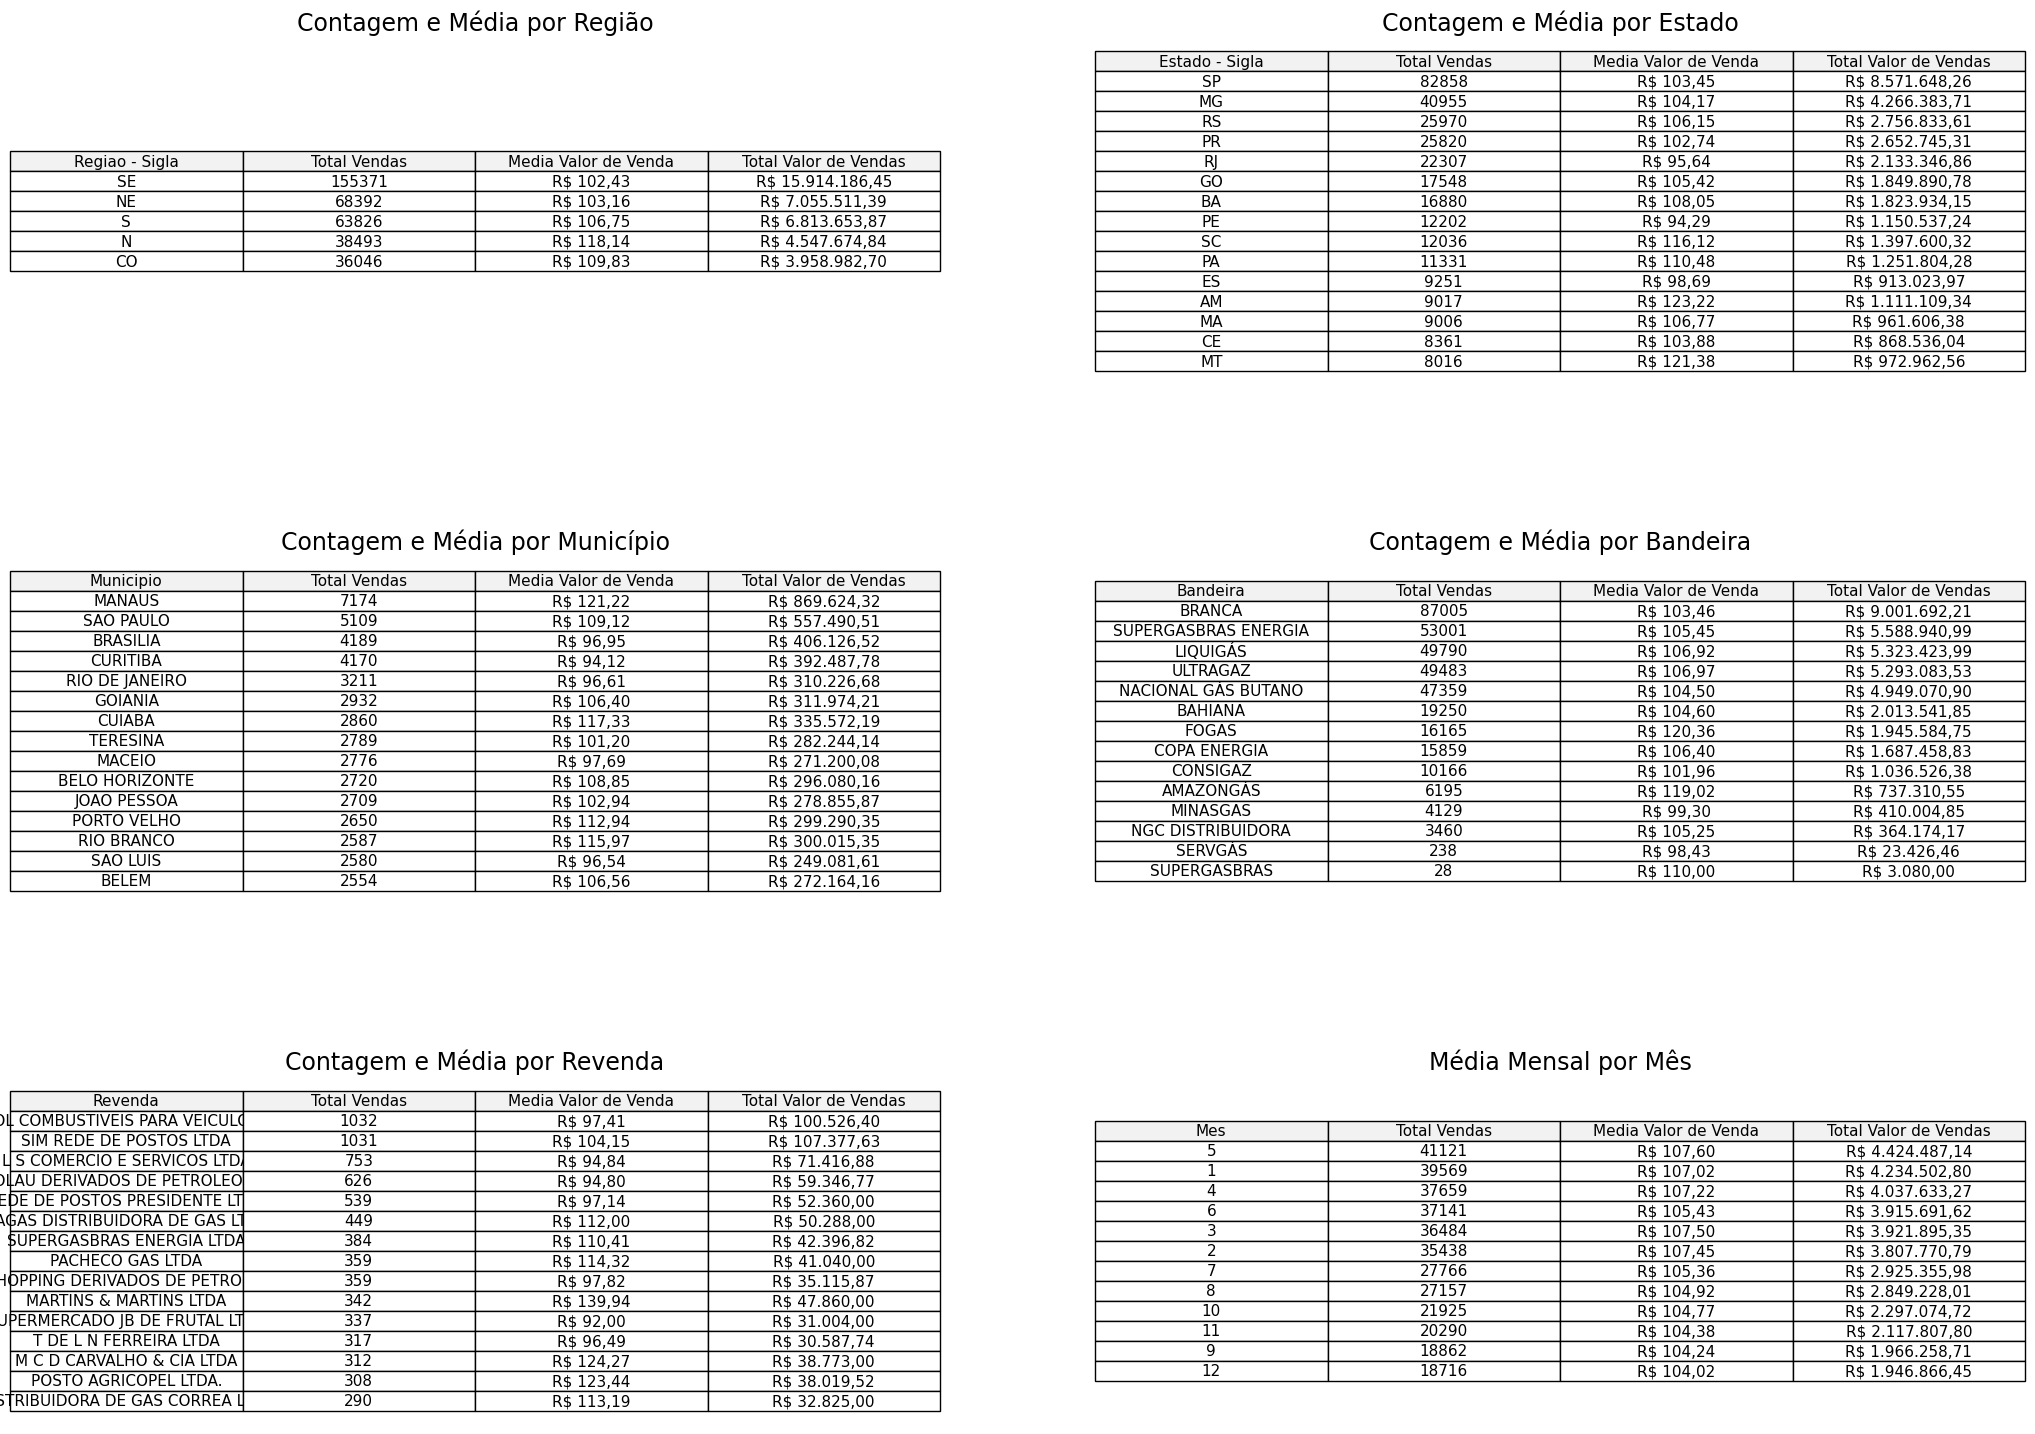

In [4]:
# Agrupando e calculando os totais para cada categoria
region_count_pd = union_df.groupBy("Regiao - Sigla").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")  # Calculando o Total Valor de Vendas
).toPandas()

state_count_pd = union_df.groupBy("Estado - Sigla").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")  # Calculando o Total Valor de Vendas
).toPandas()

municipio_count_pd = union_df.groupBy("Municipio").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")  # Calculando o Total Valor de Vendas
).toPandas()

bandeira_count_pd = union_df.groupBy("Bandeira").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")  # Calculando o Total Valor de Vendas
).toPandas()

# Agrupando os dados por Revenda e calculando os totais
revenda_count_pd = union_df.groupBy("Revenda").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")  # Calculando o Total Valor de Vendas
).toPandas()

# Agrupando os dados por mês e calculando os totais
data_count_pd = union_df.groupBy(month(union_df["Data da Coleta"]).alias('Mes')).agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    (avg("Valor de Venda") * count("id_venda")).alias("Total Valor de Vendas")  # Calculando o Total Valor de Vendas
).toPandas()

# Formatar os valores monetários
for df in [region_count_pd, state_count_pd, municipio_count_pd, bandeira_count_pd, revenda_count_pd, data_count_pd]:
    df["Media Valor de Venda"] = df["Media Valor de Venda"].apply(lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
    df["Total Valor de Vendas"] = df["Total Valor de Vendas"].apply(lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Criar uma figura com subplots
fig, axs = plt.subplots(3, 2, figsize=(24, 18))

# Ajustar o espaçamento entre os subplots
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Definindo os parâmetros para as tabelas
tables_info = [
    (region_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Região"),
    (state_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Estado"),
    (municipio_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Município"),
    (bandeira_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Bandeira"),
    (revenda_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Revenda"),
    (data_count_pd.sort_values(by="Total Vendas", ascending=False), "Média Mensal por Mês")
]

# Loop para exibir os resultados nas subplots
for ax, (data, title) in zip(axs.flatten(), tables_info):
    if not data.empty:
        ax.axis('off')
        ax.set_title(title, fontsize=17)

        # Selecionar as colunas corretas para exibição
        table_data = data[['Regiao - Sigla', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Regiao - Sigla' in data.columns else \
                     data[['Estado - Sigla', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Estado - Sigla' in data.columns else \
                     data[['Municipio', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Municipio' in data.columns else \
                     data[['Bandeira', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Bandeira' in data.columns else \
                     data[['Revenda', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Revenda' in data.columns else \
                     data[['Mes', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']]

        table = ax.table(cellText=table_data.head(15).values,
                         colLabels=table_data.columns,
                         cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(table_data.columns))
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.2)  # Ajusta a escala da tabela para que se adapte ao tamanho da fonte
    else:
        ax.axis('off')  # Desativa o eixo para subplots vazios

# Exibir a tabela
plt.show()

In [5]:
revenda_info = union_df.filter(union_df["Revenda"] == "SIM REDE DE POSTOS LTDA").agg(
    count("id_venda").alias("Total Vendas")
).toPandas()

print(revenda_info)

   Total Vendas
0          1031


In [6]:
## Juntar union_df com localizacao_df para obter latitudes e longitudes (utilizamos a base de cadastro de municipios do IBGE para pegar a LAT e LONG)
merged_df = union_df.join(localizacao_df, union_df["Municipio"] == localizacao_df["NM_MUNICIPIO"], "inner")

# Calcular o total de vendas por município
vendas_por_municipio = merged_df.groupBy("NM_MUNICIPIO", "LONG", "LAT").agg(
    F.count("id_venda").alias("Total Vendas")
).toPandas()  # Convertendo para Pandas para facilitar a manipulação

# Criar o Mapa de Calor
mapa = folium.Map(location=[-15.7801, -47.9292], zoom_start=4)  # Centro do Brasil

# Adicionar os pontos ao mapa
heat_data = [[row['LAT'], row['LONG'], row['Total Vendas']] for index, row in vendas_por_municipio.iterrows()]
HeatMap(heat_data).add_to(mapa)

# Salvar o mapa em um arquivo HTML
mapa.save("mapa_calor_vendas.html")
mapa

In [7]:
# Exportando o DataFrame union_df para um arquivo CSV para dar aquela checadinha esporadicamente  se está tudo okkk
#output_path = "union_df2.csv"

# Escrevendo o DataFrame em formato CSV com uma única partição
#union_df.coalesce(1).write.option("header", "true").csv(output_path)

#print(f"DataFrame exportado com sucesso para {output_path}")

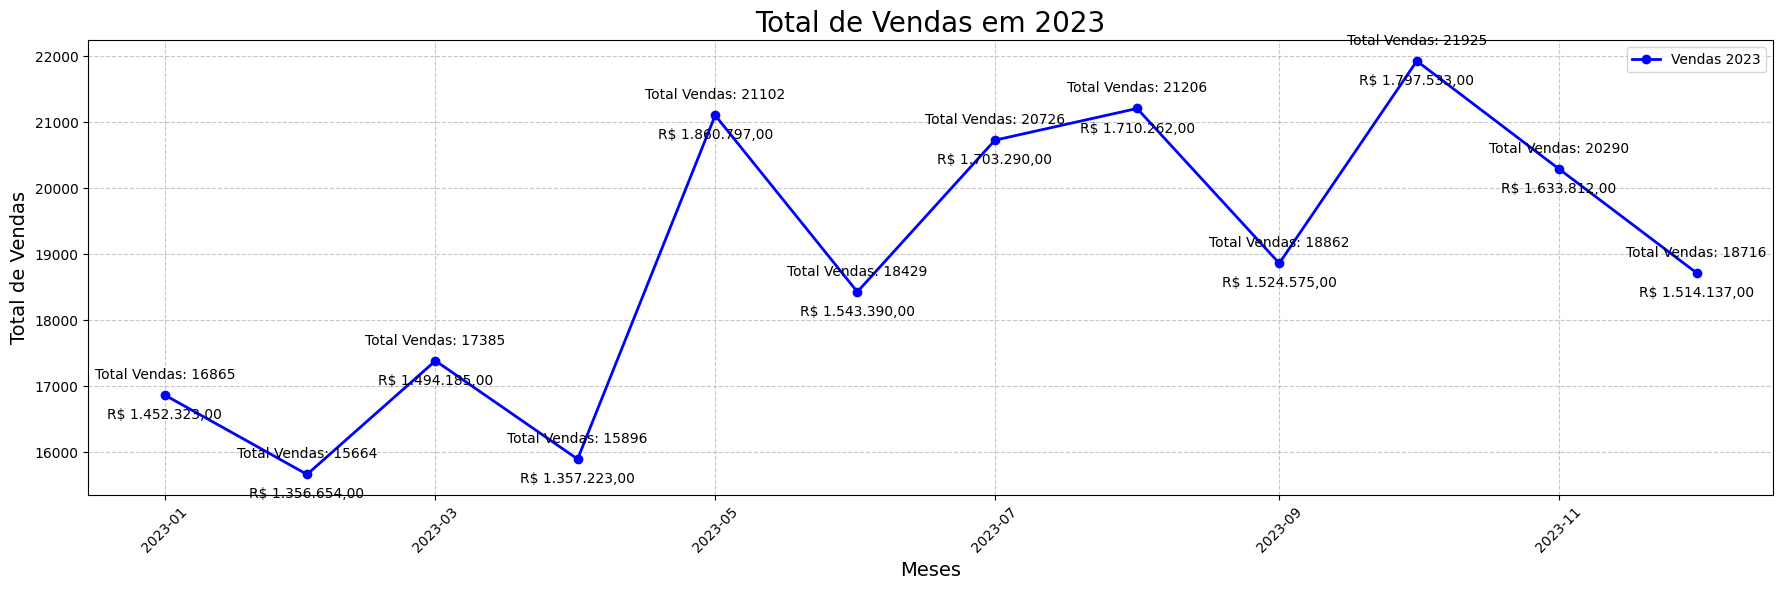

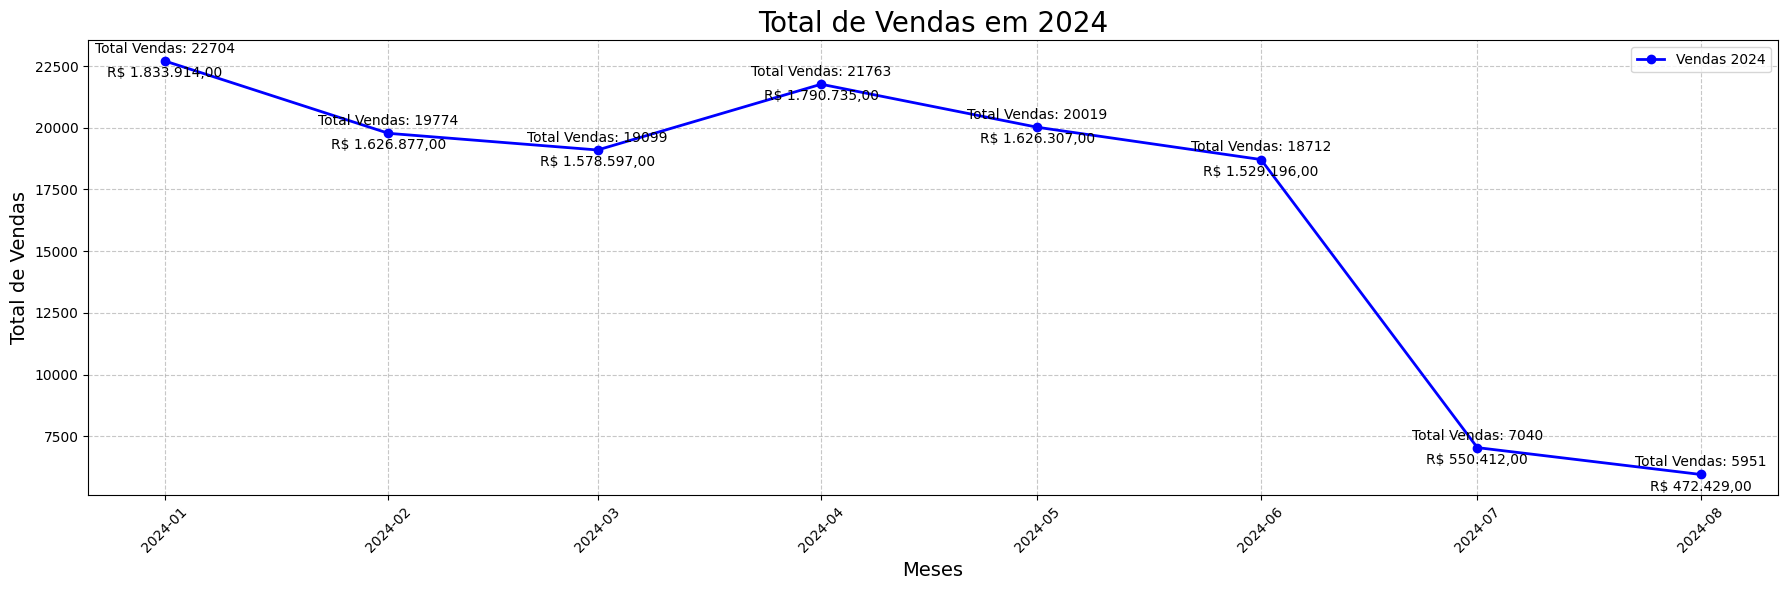

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Função para formatar valores monetários
def formatar_valor(valor):
    return f"R$ {valor:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

# Função para criar gráfico de vendas em linha com rótulos
def plot_vendas_linha(vendas_pd, ano):
    x = vendas_pd['Data']
    y = vendas_pd['Total_Vendas']
    valor_venda = vendas_pd['Valor_Venda']  # Coluna correta

    plt.figure(figsize=(18, 6))

    # Gráfico de linha
    plt.plot(x, y, marker='o', label=f'Vendas {ano}', color='blue', linewidth=2)
    plt.title(f'Total de Vendas em {ano}', fontsize=20)
    plt.xlabel('Meses', fontsize=14)
    plt.ylabel('Total de Vendas', fontsize=14)

    # Formatar o eixo x para mostrar apenas os meses
    plt.xticks(rotation=45)

    # Adicionando grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adicionar rótulos com o número total de vendas e valor total formatado
    for i in range(len(y)):
        total_valor = valor_venda[i]  # Usar diretamente o valor da venda

        # Ajuste dinâmico da posição dos rótulos para evitar sobreposição
        offset = 0.009 * max(y)  # Reduzindo a altura do deslocamento

        # Rótulo com o número de vendas
        plt.text(x[i], y[i] + offset, f'Total Vendas: {y[i]}', ha='center', va='bottom')

        # Rótulo com o valor total formatado
        plt.text(x[i], y[i] - offset, formatar_valor(total_valor), ha='center', va='top')

    # Ajustes finais
    plt.legend()
    plt.tight_layout()
    plt.show()

# Filtrar e agrupar dados para 2023
vendas_2023 = union_df.filter(union_df['Ano'] == 2023) \
    .withColumn('Mes', F.month(union_df['Data da Coleta'])) \
    .groupBy('Mes').agg(
        F.count('id_venda').alias('Total_Vendas'),
        F.sum('Valor de Venda').alias('Valor_Venda')
    ).orderBy('Mes')

vendas_2023_pd = vendas_2023.toPandas()
vendas_2023_pd['Data'] = pd.to_datetime(vendas_2023_pd['Mes'].astype(str) + '-01-2023')

# Filtrar e agrupar dados para 2024
vendas_2024 = union_df.filter(union_df['Ano'] == 2024) \
    .withColumn('Mes', F.month(union_df['Data da Coleta'])) \
    .groupBy('Mes').agg(
        F.count('id_venda').alias('Total_Vendas'),
        F.sum('Valor de Venda').alias('Valor_Venda')
    ).orderBy('Mes')

vendas_2024_pd = vendas_2024.toPandas()
vendas_2024_pd['Data'] = pd.to_datetime(vendas_2024_pd['Mes'].astype(str) + '-01-2024')

# Plotar gráficos separados
plot_vendas_linha(vendas_2023_pd, 2023)
plot_vendas_linha(vendas_2024_pd, 2024)

In [9]:
union_df.show(10)

+--------+--------------+--------------+-----------------+--------------------+--------------------+----------+----------------+--------------------+---------+--------------+--------------+--------------------+----+
|id_venda|Regiao - Sigla|Estado - Sigla|        Municipio|             Revenda|         Nome da Rua|Numero Rua|     Complemento|              Bairro|      Cep|Data da Coleta|Valor de Venda|            Bandeira| Ano|
+--------+--------------+--------------+-----------------+--------------------+--------------------+----------+----------------+--------------------+---------+--------------+--------------+--------------------+----+
|       0|            CO|            MS|     CAMPO GRANDE|COMPANHIA ULTRAGA...|RUA AMARO CASTRO ...|      1852|   Não Informado|VILA NOVA CAMPO G...|79106-361|    2023-01-05|           120|            ULTRAGAZ|2023|
|       1|            CO|            MS|     CAMPO GRANDE|SUPERGASBRAS ENER...|RUA   NILO JAVARI...|       841|   Não Informado|        

In [15]:
# Converter a coluna 'Data da Coleta' para o tipo de data
union_df = union_df.withColumn("Data da Coleta", to_date(union_df["Data da Coleta"], "dd/MM/yyyy"))

# Criar colunas 'Ano' e 'Mes'
union_df = union_df.withColumn('Mes', F.month(union_df['Data da Coleta']))  # Criando a coluna 'Mes'
union_df = union_df.withColumn('Ano', F.year(union_df['Data da Coleta']))  # Criando a coluna 'Ano'

# Agrupar dados por Região, Estado, Bandeira, Ano e Mês
vendas_agrupadas = union_df.groupBy('Regiao - Sigla', 'Estado - Sigla', 'Bandeira', 'Ano', 'Mes').agg(
    F.mean('Valor de Venda').alias('Media_Valor_Venda')
).orderBy('Regiao - Sigla', 'Estado - Sigla', 'Bandeira', 'Ano', 'Mes')

# Converter para Pandas DataFrame
vendas_pd = vendas_agrupadas.toPandas()

# Criar uma coluna para o mês em formato string
vendas_pd['Mes'] = vendas_pd['Mes'].astype(str) + '-' + vendas_pd['Ano'].astype(str)

# Pivotar os dados para criar a matriz
matriz = vendas_pd.pivot_table(index=['Regiao - Sigla', 'Estado - Sigla', 'Bandeira'],
                                columns='Mes',
                                values='Media_Valor_Venda')

# Calcular variação em relação ao mês anterior
variacao = matriz.diff(axis=1)

# Calcular variação percentual
variacao_percentual = (variacao / matriz.shift(1)) * 100

# Adicionar setas
setas = np.where(variacao > 0, '↑', '↓')
setas[variacao.isna()] = ''  # Remover setas para NaN

# Criar um DataFrame com setas e porcentagens
setas_df = pd.DataFrame(setas, index=matriz.index, columns=matriz.columns)
percentuais_df = pd.DataFrame(variacao_percentual, index=matriz.index, columns=matriz.columns)

# Criar um gráfico interativo com Plotly
fig = go.Figure(data=go.Heatmap(
    z=matriz.values,
    x=matriz.columns,
    y=matriz.index,
    colorscale='Viridis'
))

fig.update_layout(title='Matriz de Variação do Valor de Venda',
                  xaxis_title='Meses',
                  yaxis_title='Região - Estado - Bandeira')

fig.show()

# Exibir a matriz com setas e porcentagens
resultado_final = pd.concat([matriz, setas_df.add_prefix('Seta_'), percentuais_df.add_prefix('Percentual_')], axis=1)
print(resultado_final)

Mes                                                     1-2023      1-2024  \
Regiao - Sigla Estado - Sigla Bandeira                                       
CO             DF             BRANCA                103.370370   90.533333   
                              CONSIGAZ              105.000000         NaN   
                              LIQUIGÁS              111.000000         NaN   
                              NACIONAL GÁS BUTANO   100.000000   90.000000   
                              SUPERGASBRAS ENERGIA  101.081081   91.666667   
...                                                        ...         ...   
SE             SP             NACIONAL GÁS BUTANO   106.490566   99.000000   
                              NGC DISTRIBUIDORA     115.105263  111.000000   
                              SERVGÁS               100.777778   96.111111   
                              SUPERGASBRAS ENERGIA  105.718045   98.082418   
                              ULTRAGAZ              113.136296  